# Identity Neural Network
One simple yet powerful test of a neural network system is an identity model – a network that outputs exactly what it receives as input. In this tutorial, we demonstrate how to build and deploy an identity neural network using Liquid Instruments’ Moku API. This example uses a sliding window of 100 input samples (from one channel) and produces an output that is essentially the same signal, downsampled by a factor of 100 (outputting one sample per 100-input frame). This approach can verify that the Moku Neural Network instrument preserves signal integrity, and it illustrates the workflow for defining, quantizing, and testing a custom neural network model on the Moku hardware. We'll walk through the following steps:
1. Prepare the environment: Install required packages and import libraries.
2. Build the identity model: Define a network architecture (one linear layer) that should learn a direct mapping from input to output, and configure it with identity weights.
3. Test the model: Use the model to process data and visualize the output to confirm it matches the input.

## 1. Prepare the environment
First, ensure that the Moku API (with neural network support) and its dependencies are installed or updated.

In [1]:
! python.exe -m pip install --upgrade pip
! pip install --upgrade moku
! pip install zeroconf
%pip install --q moku[neuralnetwork]


Note: you may need to restart the kernel to use updated packages.


After installing the packages, import the relevant Python libraries. We import NumPy for numerical operations, Matplotlib for plotting, and the Moku neural network classes (LinnModel and save_linn) from the moku.nn module. We also set a random seed for reproducibility when generating data

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    raise


## 2. Build and Configure the Identity Model

For this example, we will configure an identity neural network that takes an input vector of length 100 and outputs the same vector (thus implementing an identity function on that window of data). Using 100 points is convenient because the Moku Neural Network supports up to 100 inputs in a single layer, and it represents a typical frame length for processing time-series data. 

In [3]:
'''Generate a sample input
Here we create a random input signal consisting of 100 random values. 
In a real scenario, this could be a segment of your time-series data. '''
frame_length = 100
data = np.random.rand(frame_length).astype(np.float32)

Initialize the model: we use LinnModel from the Moku API to create a quantized neural network model container. This object will allow us to define layers, train or configure the network, and eventually export it for deployment.

In [4]:
quant_mod_identity = LinnModel()

Since no actual training is performed, the term "training data" shouldn't be interpreted in the conventional sense. In this context, it's simply used to meet the neural network API's requirement for specifying a training dataset and to define the input dimensions.

We specify scale=False to indicate that the data is already in the normalized range expected by the model (Moku assumes inputs and outputs in the range [-1, 1] by default, but our random data is 0 to 1; for this simple example we skip any scaling)

In [5]:
quant_mod_identity.set_training_data(training_inputs=data, 
                                     training_outputs=data, 
                                     scale=False)




Define the network architecture: our identity model will consist of a single Dense layer with 100 neurons (matching the input length) and a linear activation function. A linear activation means no transformation (output = weighted sum of inputs), which is suitable for an identity pass-through. Essentially, we want the layer's weight matrix to become the identity matrix and the bias vector to be zero, so that the output equals the input:

In [6]:
# Define a single-layer neural network: 100 neurons, linear activation
model_definition = [(frame_length, 'linear')]

# Build the model architecture as specified
quant_mod_identity.construct_model(model_definition)

At this point, the model has been constructed. Initially, the weights in the dense layer are randomly initialized (as is typical for neural networks), and biases start at zero. We will verify and then override these weights to turn the network into a true identity mapper. 

The LinnModel uses Keras under the hood, so we can access the underlying Keras model to check the layer weights. The model's first layer (layers[0]) is an input layer, and the second layer (layers[1]) is our Dense layer. Let's fetch the Dense layer and look at its weight matrix and bias vector before configuring the identity NN

In [7]:
dense_layer = quant_mod_identity.model.layers[1]  # The Dense layer

# Get the initial weights and biases (Keras initialization)
kernel_weights, bias_vector = dense_layer.get_weights()
print("Initial kernel weights:\n", kernel_weights)
print("\nInitial bias vector:\n", bias_vector)


Initial kernel weights:
 [[ 0.07917216 -0.16061579 -0.0391371  ... -0.11923513 -0.00936669
  -0.09113561]
 [-0.01727246  0.06105065  0.0290999  ...  0.09953511  0.15080824
   0.04756592]
 [-0.10908251  0.04113136 -0.02809361 ...  0.02425034  0.06825413
  -0.00109209]
 ...
 [-0.05046514 -0.06880467 -0.14610206 ...  0.06448895 -0.07627211
   0.04035893]
 [-0.04015853  0.08630258  0.10605353 ... -0.06075738  0.03931281
  -0.14090794]
 [-0.11758211  0.06698248  0.02708969 ... -0.1637105   0.03663266
  -0.08311655]]

Initial bias vector:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [8]:
# Manually set weights to identity
identity_matrix = np.eye(frame_length, dtype=np.float32)
zero_bias = np.zeros(frame_length, dtype=np.float32)

print('Identity Matrix \n', identity_matrix, '\n')
print('Zero Bias \n', zero_bias)

Identity Matrix 
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 

Zero Bias 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


As expected, the biases are zero, and the weights are random small numbers. We need to replace these with an identity.

To achieve that, We will set the Dense layer's weight matrix to the identity matrix and its bias vector to all zeros. The identity matrix has ones on the diagonal and zeros elsewhere, which will make each output neuron copy the corresponding input neuron’s value. We already know the desired identity matrix should be of shape 100×100 in this case. We can create it using np.eye. Let's apply these  weights to the model and verify it worked correctly

In [9]:
# Create an identity matrix and zero bias vector of length 100
identity_matrix = np.eye(frame_length, dtype=np.float32)
zero_bias = np.zeros(frame_length, dtype=np.float32)

# Overwrite the Dense layer's weights with the identity matrix and zero biases
dense_layer.set_weights([identity_matrix, zero_bias])

# Retrieve the weights again to confirm they were set correctly
kernel_weights, bias_vector = dense_layer.get_weights()
print("Kernel weights after setting to identity:\n", kernel_weights)
print("\nBias vector after setting to zero:\n", bias_vector)


Kernel weights after setting to identity:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

Bias vector after setting to zero:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


Now our neural network is truly an identity function for a 100-sample input frame. We did not need to run a training loop in this case because we manually configured the weights to achieve perfect accuracy from the start.

The last step in building the model is to export it to a file that can be loaded onto the Moku device. We use save_linn for this, specifying the number of input and output channels and the file name. Because our model processes one input channel and produces one output channel, we set input_channels=1 and output_channels=1. We also use the output_mapping parameter to select which element of the model's output vector should map to the physical output channel of the instrument. In this identity example, since the output vector is the same as the input vector, we choose the last element (index 99) to output (this effectively means the model outputs the latest sample of each 100-sample frame)

In [10]:
model_filename = "AD_model_identity.linn" # Save the model to a .linn file for the Moku Neural Network instrument

# The output_mapping [frame_length-1] means: output the last sample of the 100-length output vector
save_linn(quant_mod_identity, input_channels=1, output_channels=1, 
          file_name=model_filename, output_mapping=[frame_length-1])


Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 103 cycles


# 3. Testing the model

We can now test the identity NN model, expecting the output to match the input signal, as every layer of the NN passes the preserved information from input to output. With the identity neural network built and saved, we can perform a quick test to ensure it behaves as expected. We will use the model to predict an output from the input data and then compare or plot the result. Since this is an identity model, the output should match the input exactly (aside from any minor numerical precision differences). In a deployed scenario on the Moku hardware, the model would continuously process incoming data frames and output the selected sample. For our offline test, we use the LinnModel.predict() method on the same data we used to configure the model

In [11]:
# Use the model to reconstruct the output from the input
reconstructed_output = quant_mod_identity.predict(data.reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Here, data.reshape(1, -1) shapes our data array into the expected input format (a batch of 1 frame by 100 samples). The predict function returns a NumPy array; in this case reconstructed_output will be of shape (1, 100).

Now let's visualize the original signal versus the reconstructed signal to confirm they are identical

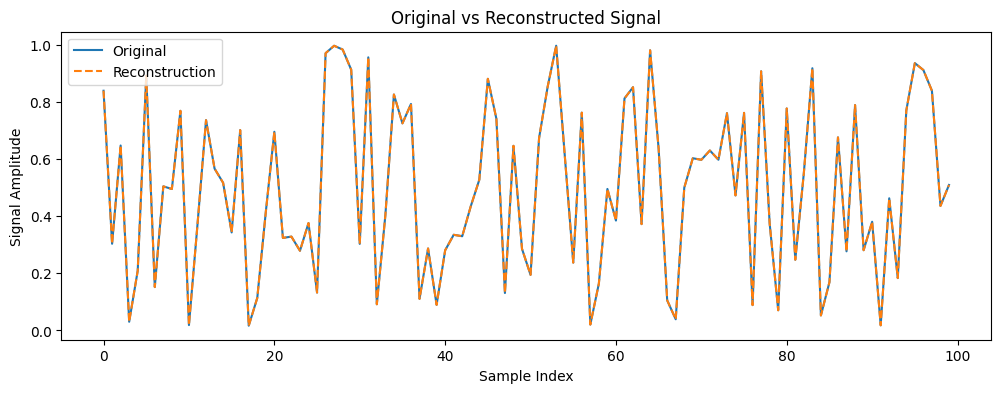

In [12]:
plt.figure(figsize=(12,4))
plt.plot(data, label='Original')
plt.plot(reconstructed_output[0], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Signal Amplitude')
plt.show()


The identity model’s performance: the Original input signal (solid orange line) and the Reconstructed output signal (dashed blue line) completely overlap. The output from the neural network is identical to the input, confirming that the model passes the signal through without alteration.

We successfully constructed and verified an identity neural network using the Moku API. This simple example serves as a baseline test for the Moku Neural Network instrument’s precision and can act as a starting point for more complex models. You can now deploy the saved .linn model to your Moku device, where it should output a signal identical to the input. This confirms that the neural network pipeline on the device can preserve signal values accurately, and it provides confidence before moving on to training more sophisticated models on your data.